In [1]:
import numpy as np
from modules import Cannon, Pressure, WaveLong, WaveTang
import matplotlib.pyplot as plt
from scipy.linalg import solve

# 1. Ballistic and Geometry

In [2]:
d = 125*1e-3          # калибр м
q = 7.05           # вес снаряда кг
velocity_pm = 1700         # дульная скорость снаряда
n_s = 1           # нарезное орудие
max_pressure = 600*1e6    # максимальное давление Па
tube_lenght = 5543*1e-3      # длина трубы     
p_fors = 10*1e6
l_pr = 0.7 # длина снаряда

pow_name = "МАП-1 23/1"
wq, ro = 1.178537, 737.374805

rho = 7800
E = 200e9
vi = 0.25
g = 9.81

# geometry grid
n_x = 500

init_dict = {
   'powders': 
    [
       {'omega': wq*q,
       'dbname': pow_name}
    ],
    'init_conditions': 
    {
       'q': q,
       'd': d,
       'W_0': wq*q/ro,
       'phi_1': 1.0,
       'p_0': p_fors, 
       'n_S': n_s
    },
    'igniter': 
    {
       'p_ign_0': 5_000_000.0 #check it 
    },
  
    'meta_lagrange': 
    {
       'CFL': 0.9, 
       'n_cells': 300
    },
    'stop_conditions': 
    {
       'x_p': tube_lenght,
       'steps_max': 8000,   
       't_max': 0.08,
       'p_max': max_pressure,
    }
    }

In [3]:
Cannon.ro = rho
ball = Pressure(init_dict)
ball.calculate()
geometry = Cannon()
geometry.cannon_geometry(d, ball.l0, ball.l_tube)
ball.make_func(geometry.l_kam, l_pr)

beam_r2_x = np.array([0, 0.4, 0.5, 0.8, geometry.r_inside_coordinate[-1]])
beam_r2 = np.array([0.16, 0.16, 0.16, 0.14, 0.09])
geometry.outside_geometry(beam_r2_x, beam_r2)
geometry.make_func()
geometry.make_dsdx(n_x)

# 3. Wave x (long)

In [19]:
displ = 0 
n_t = 1000

dt = ball.t_end/n_t
T = ball.t_end # time stop
T_st = 0
L = geometry.L - displ
C = 0.75 # the Courant number (=max(c)*dt/dx).

### Solve euption

In [7]:
%%time
wave_x = WaveLong(geometry, T, dt, T_st, mass_on=False)
wave_x.add_pressure(ball, projectile=False)
wave_x.solver()


 T: 0.008
 T_st: 0
 Mass: False
 Pressure: True

N_x =  119
CPU times: total: 15.8 s
Wall time: 15.9 s


In [8]:
wave_x.grid_u.shape, wave_x.grid_t[100_000:].shape

((1001, 120), (0,))

In [9]:
def u(x, t):
    if t < 0:
        return np.zeros_like(x)
    points = np.array([x, (t+wave_x.T_st)*np.ones_like(x)]).T
    return wave_x.u(points)

In [10]:
u(6, ball.t_end/1.2)

array([-0.000147])

### Vizualization

In [11]:
%matplotlib widget
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [12]:
#%matplotlib inline 
#%config InlineBackend.figure_format = 'svg' 
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

In [13]:
plt.ioff()

i_start = wave_x.grid_u.shape[0] - round(T/wave_x.dt)

step_slider = widgets.IntSlider(
    orientation='horizontal',
    value=0, 
    min=0, max=wave_x.grid_t[i_start:].shape[0], step=1, 
    description='step'
)

step_slider.layout.margin = '0px 30% 0px 30%'
step_slider.layout.width = '40%'

fig = plt.figure(figsize=(10,6))
fig.canvas.header_visible = False
fig.canvas.layout.min_height = '400px'
#plt.title('Plotting step: {}'.format(data_x[step_slider.value]['t_s']))

#line1 = plt.plot(grid_x, u[0]*1e6, lw=1)
line2 = plt.plot(wave_x.grid_x, wave_x.grid_u[i_start]*1e6, lw=1)

plt.xlabel('$x$, м', fontsize=16)
plt.ylabel('$u$, мкм', fontsize=16)
plt.xlim(0, 7)
plt.ylim(-200, 200)
plt.grid()


def update_lines(change):
    #plt.title('Plotting step: {}'.format(data_x[step_slider.value]['t_s']))
    #line1[0].set_data(grid_x, u[change.new]*1e6)
    line2[0].set_data(wave_x.grid_x, wave_x.grid_u[i_start+change.new]*1e6)
    fig.canvas.draw()
    fig.canvas.flush_events()

step_slider.observe(update_lines, names='value')

widgets.AppLayout(
    center=fig.canvas,
    footer=step_slider,
    pane_heights=[0, 6, 1]
)

AppLayout(children=(IntSlider(value=0, description='step', layout=Layout(grid_area='footer', margin='0px 30% 0…

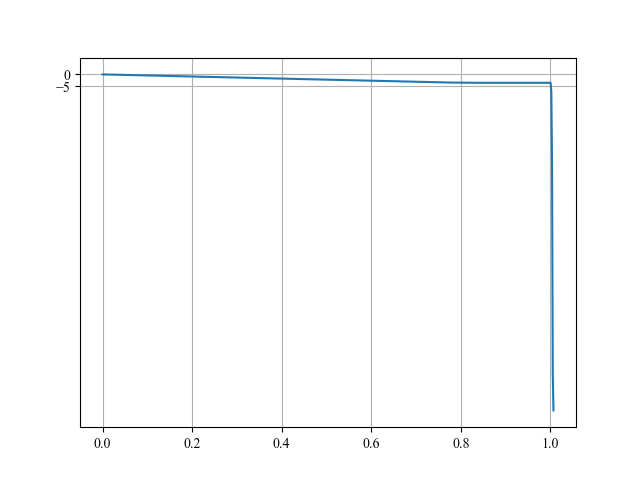

In [15]:
#%matplotlib inline 
#%config InlineBackend.figure_format = 'svg' 
fig2, ax = plt.subplots(1,1)
ax.plot(wave_x.grid_t[::100], wave_x.grid_u[::100,-1]*1e6)
ax.set_yticks(np.arange(-5, 5, 5))
plt.grid()
plt.show()

# 4. Wave y (tang)

In [14]:
def find_A(u, x):
    
    arr_u = []
    arr_x = []
    add = False 
    b = u[-1]
    c = x[-1]
    for i in range(len(u)-1, -1, -1):
        if u[i] > b:
            add = True
            b = u[i]
            c = x[i]
        elif add:
            add = False
            arr_u.append(b)
            arr_x.append(c)
    return np.array(arr_u[::-1]), np.array(arr_x[::-1])

In [20]:
ball.t_end, dt

(0.007916475936787449, 7.91647593678745e-06)

In [81]:
T_st = 6
T = 5*ball.t_end
dt = 5e-5
dx = 1e-2

In [82]:
T, dt, dx

(0.03958237968393724, 5e-05, 0.01)

In [83]:
wave_y = WaveTang(geometry, T, dt,T_st=T_st, mass_on=True, dx_user=dx)
#wave_y.add_pressure(ball, u, projectile=True)
wave_y.init_condition()

In [84]:
wave_y.Nt, wave_y.Nx, wave_y.dx, wave_y.dt

(120792, 636, 0.009993372289296594, 5e-05)

In [85]:
%%time
wave_y.solver()

CPU times: total: 56.2 s
Wall time: 56.3 s


### Vizualization

In [51]:
%matplotlib widget
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [54]:
#%matplotlib inline 
#%config InlineBackend.figure_format = 'svg' 
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

In [55]:
plt.ioff()

step_slider = widgets.IntSlider(
    orientation='horizontal',
    value=0, 
    min=0, max=wave_y.Nt, step=100, 
    description='step'
)

step_slider.layout.margin = '0px 30% 0px 30%'
step_slider.layout.width = '40%'

fig = plt.figure(figsize=(10,6))
fig.canvas.header_visible = False
fig.canvas.layout.min_height = '400px'
#plt.title('Plotting step: {}'.format(data_x[step_slider.value]['t_s']))

line1 = plt.plot(wave_y.grid_x, wave_y.grid_v[0]*1e6, lw=1)

plt.xlabel('$x$, м', fontsize=16)
plt.ylabel('$u$, мкм', fontsize=16)
plt.xlim(0, 7)
plt.ylim(-100, 100)
plt.grid()


def update_lines(change):
    #plt.title('Plotting step: {}'.format(data_x[step_slider.value]['t_s']))
    line1[0].set_data(wave_y.grid_x, wave_y.grid_v[change.new]*1e6)
    fig.canvas.draw()
    fig.canvas.flush_events()

step_slider.observe(update_lines, names='value')

widgets.AppLayout(
    center=fig.canvas,
    footer=step_slider,
    pane_heights=[0, 6, 1]
)

IndexError: list index out of range

In [79]:
ampl, x_ampl = find_A(wave_y.grid_v[:,-1], wave_y.grid_t)

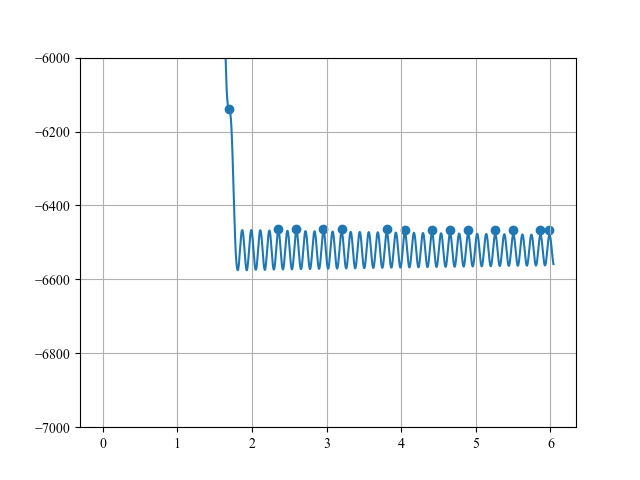

In [86]:
fig2, ax = plt.subplots(1,1)
ax.plot(wave_y.grid_t[:], wave_y.grid_v[:,-1]*1e6)
#plt.yticks(np.arange(-5, 5, 0.5))
ax.scatter(x_ampl, ampl*1e6)
plt.ylim(-7000, -6000)
plt.grid()
plt.show()

In [45]:
dicrement = np.mean(ampl[:-1]/ampl[1:])
dicrement

0.873715988668518

# 5. Furie Wave

In [87]:
i = 10
n_x = 1000

In [429]:
class FourierWave:
    
    g = 9.81
    epsilon = 0.021
    E = 200e9
    
    def __init__(self, geometry, nx, i=3, seal_move=0):
        
        self.geom = geometry
        self._L = geometry.L 
        self.nx = nx
        self.forms = i
        
    def calc_coeff(self):
        
        x = np.linspace(0, self._L, self.nx)
        F = self.geom.F(x)
        J = self.geom.J(x)
        F_h = (F[1:]+F[:-1])/2
        J_h = (J[1:]+J[:-1])/2
        rho = self.geom.ro
        E = self.E
        dx = x[1] - x[0]
        self.mass = np.sum(F_h*dx*rho)
        self.inert = np.sum(J_h*dx*E)
        self.k = np.full(self.forms, rho)
        self.c = np.full(self.forms, rho)
        self.b = np.full(self.forms, E)
        for i in range(1, self.forms+1):
            a = np.pi*i/2/self._L
            self.k[i-1] *= np.sum(F_h*self.integ_1(a, x))
            self.c[i-1] *= np.sum(F_h*self.integ_2(a, x))
            self.b[i-1] *= np.abs(np.sum(J_h*self.integ_3(a, x)))
        
        self.omega = np.sqrt(self.b/self.c)
        self.A = self.k/self.b/self.omega/self.epsilon
    
    @staticmethod           
    def integ_1(a, x):
        #integ = -1/a*np.cos(a*x)
        integ = x - np.sin(a*x)/a
        return integ[1:] - integ[:-1]
    
    @staticmethod 
    def integ_2(a, x):
        #integ = 1/2/a*(a*x - np.sin(a*x)*np.cos(a*x))
        ##integ = 1/a*(np.sin(a*x) - 2*np.arctan(np.tanh(a*x/2)))
        integ = 0.25/a*(6*a*x - 8*np.sin(a*x) + np.sin(2*a*x))
        return integ[1:] - integ[:-1]
    
    @staticmethod 
    def integ_3(a, x):
        #integ = a**3/2*(a*x - np.sin(a*x)*np.cos(a*x))
        ##integ = a**3*(np.sin(a*x) - 5*np.tanh(a*x)*(1/np.cosh(a*x))**3 + np.tanh(a*x)**3*(1/np.cosh(a*x)))
        integ = 0.25*a**3*(2*a*x - 4*np.sin(a*x) + np.sin(2*a*x))
        return integ[1:] - integ[:-1]
    
    def u(self, x):
        y = np.zeros_like(x)
        for i in range(1, self.forms+1):
            arg = i*np.pi/2/self._L*x
            y += self.g*self.k[i-1]/self.b[i-1]*(1-np.cos(arg))#np.sin(arg)#
        return y
    

In [430]:
fourie = FourierWave(geometry, 1000, 3)

In [431]:
fourie.calc_coeff()

In [432]:
fourie.k, fourie.b, fourie.c

(array([ 409, 1197, 1638]),
 array([   79359.23799699,  1765788.66678832, 25120286.73454156]),
 array([ 219, 1593, 2482]))

In [433]:
fourie.omega

array([ 19.03604344,  33.29365498, 100.60311025])

In [434]:
fourie.A

array([1.28922832e-02, 9.69559924e-04, 3.08644543e-05])

In [435]:
fourie.k/fourie.b

array([5.15377932e-03, 6.77884065e-04, 6.52062621e-05])

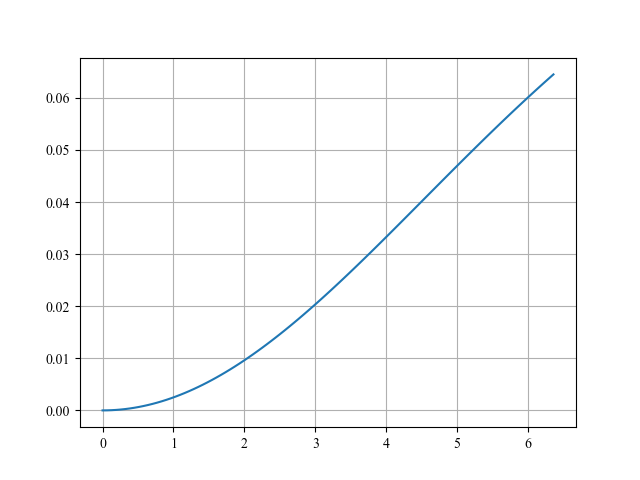

In [436]:
x = np.linspace(0, geometry.L, 100)

fig3, ax1 = plt.subplots(1,1)
ax1.plot(x, fourie.u(x))
#plt.yticks(np.arange(-5, 5, 0.5))
#ax.scatter(x_ampl, ampl*1e6)
#plt.ylim(-7000, -6000)
plt.grid()
plt.show()

### Solve Krulov

In [374]:
from scipy.linalg import solve

In [375]:
def S(z):
    return 0.5*(np.cosh(z) + np.cos(z))
def T(z):
    return 0.5*(np.sinh(z) + np.sin(z))
def U(z):
    return 0.5*(np.cosh(z) - np.cos(z))
def V(z):
    return 0.5*(np.sinh(z) - np.sin(z))

In [376]:
n = 10
z_k = [1.875] + [np.pi/2 + np.pi*(k-1) for k in range(2, n+1)]

In [377]:
A = []
for z in z_k:
    A.append(np.array([
        [S(z), T(z)],
        [V(z), S(z)]
    ]))

In [378]:
l = 6
a_k = np.array(z_k)/l

In [385]:
def w_z(x, i):
    return U(a_k[i]*x) - V(a_k[i]*x)*S(z_k[i])/T(z_k[i])

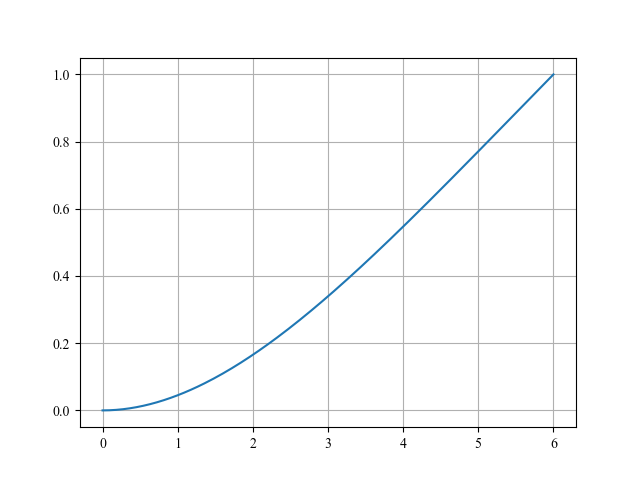

In [386]:
x = np.linspace(0, l, 200)

fig4, ax2 = plt.subplots(1,1)
ax2.plot(x, w_z(x, 0))
#plt.yticks(np.arange(-5, 5, 0.5))
#plt.ylim(-7000, -6000)
plt.grid()
plt.show()

In [317]:
S(z_k), T(z_k)

(array([1.51877677e+00, 2.78316904e+01, 6.43992721e+02, 1.49024354e+04,
        3.44852676e+05, 7.98012979e+06, 1.84665731e+08, 4.27329291e+09,
        9.88869578e+10, 2.28831270e+12]),
 array([2.06890893e+00, 2.73271988e+01, 6.44492527e+02, 1.49019354e+04,
        3.44853176e+05, 7.98012929e+06, 1.84665731e+08, 4.27329291e+09,
        9.88869578e+10, 2.28831270e+12]))

In [311]:
a_k

array([0.3125    , 0.78539816, 1.30899694, 1.83259571, 2.35619449,
       2.87979327, 3.40339204, 3.92699082, 4.45058959, 4.97418837])

In [439]:
a = [4 , 6 , 8]
b =[6, 8]

In [441]:
a.append(*b)
a

TypeError: list.append() takes exactly one argument (2 given)

In [459]:
def f(*arg, **kwargs):
    print(arg)
    print(len(kwargs))

In [460]:
f(a, 7, b, a=1)

([4, 6, 8, 6, 8], 7, [6, 8])
1


In [461]:
for i in 1..10:
    print(i)

SyntaxError: invalid syntax (1551636857.py, line 1)

In [462]:
a = [x for x in 1..10]

SyntaxError: invalid syntax (310787983.py, line 1)

In [464]:
class Foo:
    var = 1

a = Foo()
b = Foo()
a.var = 10
b.var

1

In [465]:
type({5, 7,8})

set

In [468]:
hash((7,9))

8527674585806224592